# Adaping TensorFlow Esitmator tutorial for Kaggle Customer Churn
### Source: https://www.tensorflow.org/tutorials/estimator/linear
### Source: https://www.kaggle.com/blastchar/telco-customer-churn

In [1]:
!pip install -q sklearn

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import roc_curve

In [3]:
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [4]:
# Load dataset.
csv_file = 'Telco-Customer-Churn-Cleaned.csv'
df = pd.read_csv(csv_file)

# Feature selection cirteria: Correlation
## "Remove one of two features that have a correlation higher than 0.9"
### source: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

In [5]:
df.corr()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016479,-0.211185,0.016567,0.008576,0.142948,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.156530,0.220173,0.103006,0.150889
Partner,0.016479,1.000000,0.452676,0.379697,0.017706,0.142057,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,-0.014877,0.096848,0.317504,-0.150448
Dependents,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.024526,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,-0.111377,-0.113890,0.062078,-0.164221
tenure,0.016567,0.379697,0.159712,1.000000,0.008448,0.331941,0.327203,0.360277,0.360653,0.324221,0.279756,0.286111,0.006152,0.247900,0.826178,-0.352229
PhoneService,0.008576,0.017706,-0.001762,0.008448,1.000000,0.279690,-0.092893,-0.052312,-0.071227,-0.096340,-0.022574,-0.032959,0.016505,0.247398,0.113214,0.011942
MultipleLines,0.142948,0.142057,-0.024526,0.331941,0.279690,1.000000,0.098108,0.202237,0.201137,0.100571,0.257152,0.258751,0.163530,0.490434,0.468504,0.040102
OnlineSecurity,-0.038653,0.143106,0.080972,0.327203,-0.092893,0.098108,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,-0.003636,0.296594,0.411651,-0.171226
OnlineBackup,0.066572,0.141498,0.023671,0.360277,-0.052312,0.202237,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501,0.126735,0.441780,0.509226,-0.082255
DeviceProtection,0.059428,0.153786,0.013963,0.360653,-0.071227,0.201137,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111,0.103797,0.482692,0.521983,-0.066160
TechSupport,-0.060625,0.119999,0.063268,0.324221,-0.096340,0.100571,0.354931,0.294233,0.333313,1.000000,0.278070,0.279358,0.037880,0.338304,0.431883,-0.164674


## Tenure and TotalCharges are the only features that approach being sufficiently correlated to warrent being removed.
### Leaving them in because customers vary across price plans and may vary themselves over time. 

In [6]:
df.corr()['tenure']['TotalCharges']

0.8261783979502535

# Feature selection cirteria: Permutation feature importance
## "Additionally, remove features the are less important than a random variable"
### source: https://explained.ai/rf-importance/index.html

In [7]:
df['random'] = np.random.uniform(low=0.0, high=1.0, size=(df.shape[0]))
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,random
0,Female,0,1,0,1,0,0,DSL,0,1,...,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,0.081978
1,Male,0,0,0,34,1,0,DSL,1,0,...,0,0,0,One year,0,Mailed check,56.95,1889.50,0,0.380265
2,Male,0,0,0,2,1,0,DSL,1,1,...,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,0.479835
3,Male,0,0,0,45,0,0,DSL,1,0,...,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,0.679105
4,Female,0,0,0,2,1,0,Fiber optic,0,0,...,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,0.079882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,1,1,24,1,1,DSL,1,0,...,1,1,1,One year,1,Mailed check,84.80,1990.50,0,0.683580
7039,Female,0,1,1,72,1,1,Fiber optic,0,1,...,0,1,1,One year,1,Credit card (automatic),103.20,7362.90,0,0.335956
7040,Female,0,1,1,11,0,0,DSL,1,0,...,0,0,0,Month-to-month,1,Electronic check,29.60,346.45,0,0.596618
7041,Male,1,1,0,4,1,1,Fiber optic,0,0,...,0,0,0,Month-to-month,1,Mailed check,74.40,306.60,1,0.553575


## Build a BoostedTree prediction model and Permutation feature importance algorithm

In [8]:
# Splitting the dataset into training and evaluation data
dftrain, dfeval = train_test_split(df, test_size=0.2)
print(len(dftrain), 'train examples')
print(len(dfeval), 'validation examples')

y_train = dftrain.pop('Churn')
y_eval = dfeval.pop('Churn')

5634 train examples
1409 validation examples


In [9]:
# Defining feature columns
CATEGORICAL_COLUMNS = [ 'gender','InternetService','Contract', 'PaymentMethod']

NUMERIC_COLUMNS = ['tenure','MonthlyCharges', 'TotalCharges','SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','PaperlessBilling','random']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [10]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [11]:
params = {
  'n_trees': 2,
  'max_depth': 6,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.793471
accuracy_baseline,0.735983
auc,0.843107
auc_precision_recall,0.661070
average_loss,0.443422
label/mean,0.264017
loss,0.443422
precision,0.754717
prediction/mean,0.273151
recall,0.322581


### Baseline accuracy with every feature column

In [12]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0icej1j6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

## Calculate permutation feature importance

In [13]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS 
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-07T17:08:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.57376s
INFO:tensorflow:Finished evaluation at 2020-09-07-17:08:20
INFO:tensorflow:Saving dict for global step 15: accuracy = 0.79347056, accuracy_baseline = 0.73598295, auc = 0.84310746, auc_precision_recall = 0.6610699, average_loss = 0.44342172, global_step = 15, label/mean = 0.26401705, loss = 0.44342172, precision = 0.754717, prediction/mean = 0.27315092, recall = 0.32258064
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15: /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Calling model_fn.


/home/maud/repo/telco-churn/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-07T17:08:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.69054s
INFO:tensorflow:Finished evaluation at 2020-09-07-17:08:22
INFO:tensorflow:Saving dict for global step 15: accuracy = 0.79347056, accuracy_baseline = 0.73598295, auc = 0.84304136, auc_precision_recall = 0.66091937, average_loss = 0.44347593, global_step = 15, label/mean = 0.26401705, loss = 0.44347593, precision = 0.754717, prediction/mean = 0.27314964, recall = 0.32258064
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15: /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Calling model_fn.


/home/maud/repo/telco-churn/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-07T17:08:23Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.64966s
INFO:tensorflow:Finished evaluation at 2020-09-07-17:08:23
INFO:tensorflow:Saving dict for global step 15: accuracy = 0.73314404, accuracy_baseline = 0.73598295, auc = 0.7578351, auc_precision_recall = 0.45245916, average_loss = 0.50905716, global_step = 15, label/mean = 0.26401705, loss = 0.50905716, precision = 0.48630136, prediction/mean = 0.2628542, recall = 0.19086021
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15: /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-07T17:08:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Rest

INFO:tensorflow:Finished evaluation at 2020-09-07-17:08:34
INFO:tensorflow:Saving dict for global step 15: accuracy = 0.79347056, accuracy_baseline = 0.73598295, auc = 0.84310746, auc_precision_recall = 0.6610699, average_loss = 0.44342172, global_step = 15, label/mean = 0.26401705, loss = 0.44342172, precision = 0.754717, prediction/mean = 0.27315092, recall = 0.32258064
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15: /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-07T17:08:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.72386s
INFO:tensorflow:Finished evaluation at 2020-09-07-17:08:36
INFO:tensorflow:Saving dict for global step 15: accuracy = 0.79347056, accuracy_baseline = 0.73598

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-07T17:08:46Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.60963s
INFO:tensorflow:Finished evaluation at 2020-09-07-17:08:47
INFO:tensorflow:Saving dict for global step 15: accuracy = 0.79347056, accuracy_baseline = 0.73598295, auc = 0.8394977, auc_precision_recall = 0.6595218, average_loss = 0.44575492, global_step = 15, label/mean = 0.26401705, loss = 0.44575492, precision = 0.754717, prediction/mean = 0.27237895, recall = 0.32258064
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15: /tmp/tmp0icej1j6/model.ckpt-15
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-07T17:08:47Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restor

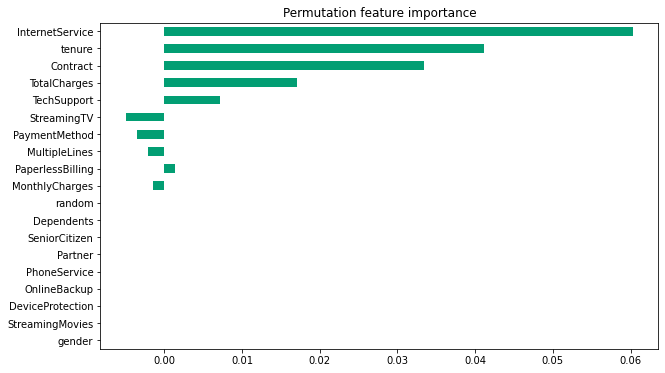

In [14]:
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-20:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

## Remove all features with importance less than 'random' and retrain the model
### Upon subsequent runs the PaperlessBilling was also eliminated

In [15]:
CATEGORICAL_COLUMNS = ['InternetService','Contract']
NUMERIC_COLUMNS = ['tenure','MonthlyCharges','TechSupport','random']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.787793
accuracy_baseline,0.735983
auc,0.841144
auc_precision_recall,0.668757
average_loss,0.444735
label/mean,0.264017
loss,0.444735
precision,0.787402
prediction/mean,0.273141
recall,0.268817


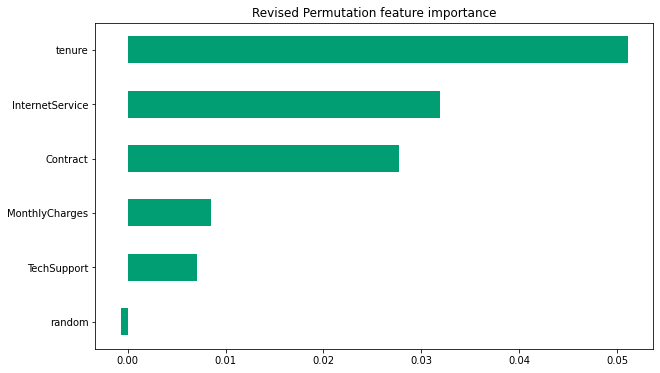

In [16]:
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS 
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)
                   
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-20:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Revised Permutation feature importance')
clear_output()
plt.show()

## TechSupport is ruled out using Gain Feature Importance

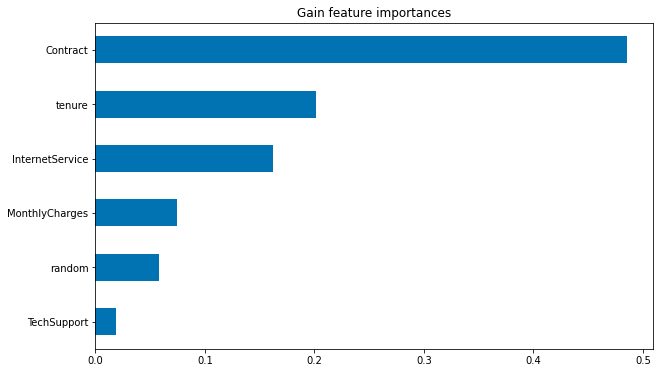

In [17]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

## Final feature set model training and evaluation

In [18]:
CATEGORICAL_COLUMNS = ['InternetService','Contract']
NUMERIC_COLUMNS = ['tenure','MonthlyCharges']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.791341
accuracy_baseline,0.735983
auc,0.843714
auc_precision_recall,0.665797
average_loss,0.443660
label/mean,0.264017
loss,0.443660
precision,0.774648
prediction/mean,0.273159
recall,0.295699


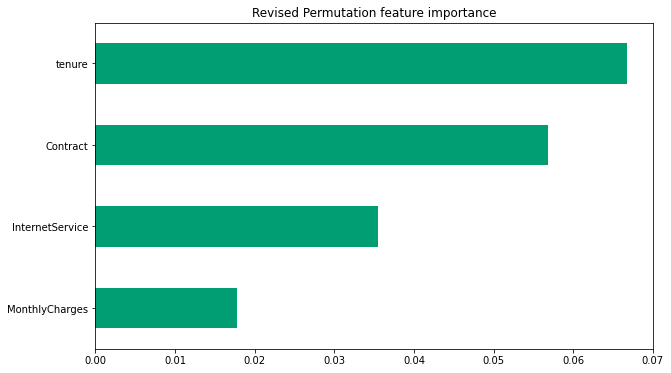

In [19]:
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS 
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)
                   
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-20:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Revised Permutation feature importance')
clear_output()
plt.show()

## Out of 19 features in the dataset only tenure, InternetService, Contract, and MonthlyCharges are significant to the model's prediction of churn 

# Local interpretability
### Output the directional feature contributions (DFCs) to explain individual predictions

In [34]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))
clear_output()

In [21]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,1409.0,-0.002620,0.052821,-0.086086,-0.038162,-0.012151,0.029089,0.153988
Contract,1409.0,-0.009578,0.039545,-0.066037,-0.051741,0.023978,0.025508,0.061682
InternetService,1409.0,0.004576,0.028969,-0.033217,-0.020455,-0.004252,0.041589,0.042596
tenure,1409.0,0.015074,0.057385,-0.080789,-0.025627,-0.010962,0.046626,0.149562


In [22]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

In [30]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='center right', shadow=True, fontsize='x-large', frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)


## Individual predictions: Example 1

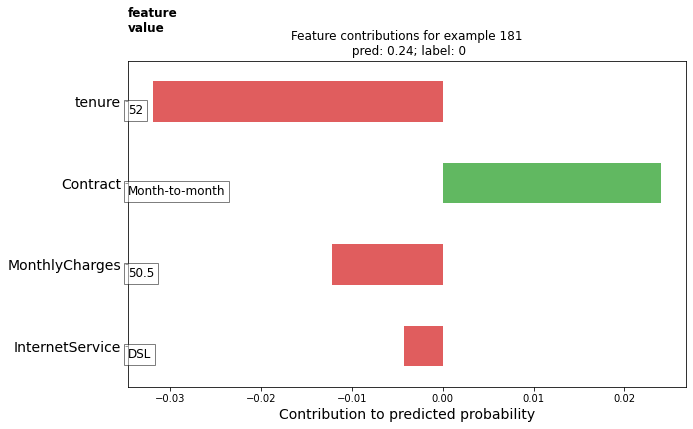

In [94]:
# Plot results.
ID = 181
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

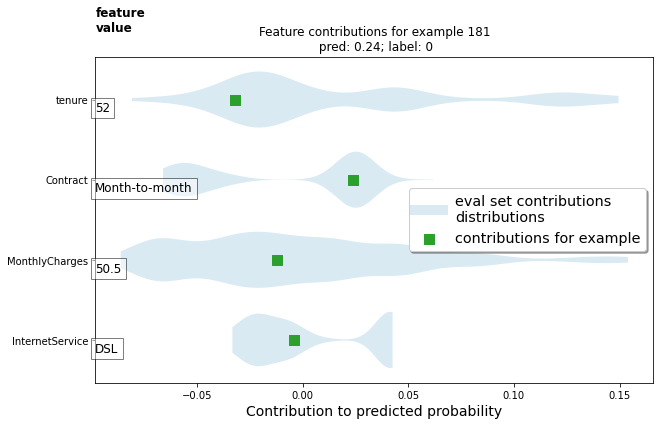

In [95]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()


## Individual predictions: Example 2


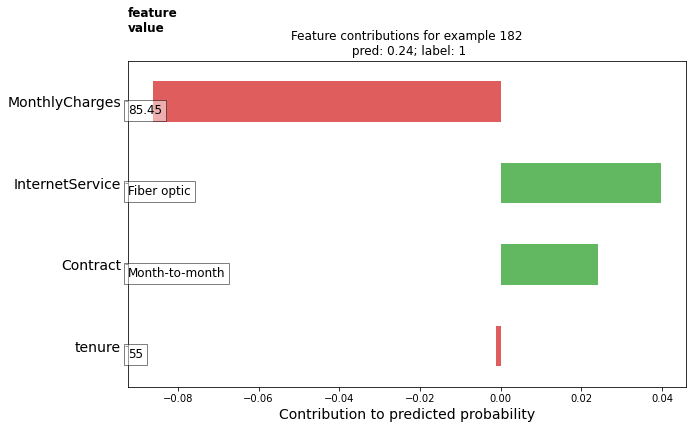

In [96]:
# Plot results.
ID = ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

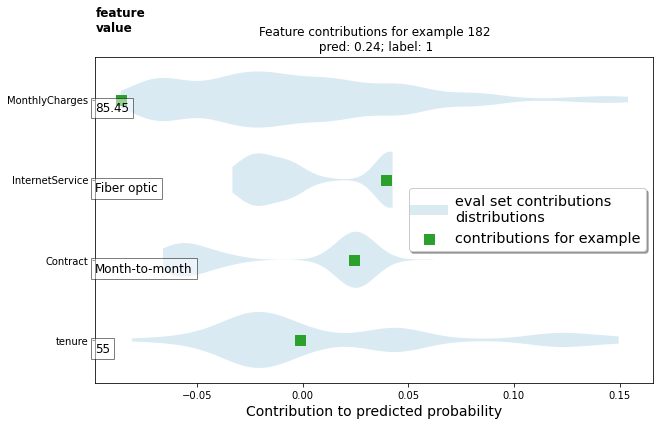

In [97]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()


# Insights:
## 1. Customer tenure is the most significant contributor to customer churn.
### High tenure can overcome the impact of other features that would cause a customer to churn.

## 2. The type of customer Contract is the next most significant predictor of churn. A Month-to-Month customer is highly likely to churn.
### Customers are unlikely to break their long term contracts.

## 3. Customers using the Fiber Optic InternetService option are likely to churn.

## 4. Customers with high monthly charges are less likely to churn.
### Higher monthly charges may correlate to more service subscriptions, leading to sticker customers. 